In [1]:
import sys

sys.path.append('submodules/vggt')

In [2]:
import pandas as pd

path_topk_dinov3 = "/home/emmanuel/Desktop/crocodl_challenge/experiments/visual_localization/megaloc.json"

df = pd.read_json(path_topk_dinov3, lines=True)

In [3]:
import random

idx = random.randint(0, len(df))
sample = df.iloc[idx]

In [4]:
import os

query_path = sample['query_path']
query_topk = sample['topk']
query_topk = {d['rank']: d for d in query_topk}

vggt_input_ref_paths = [
    query_topk[i].get('abs_path')
    for i in range(1, 5)
]
ranks = [
    query_topk[i].get('rank')
    for i in range(1, 5)
]
score = [
    query_topk[i].get('score')
    for i in range(1, 5)
]

vggt_input_paths =  [query_path] + vggt_input_ref_paths
ranks = [0.0] + ranks
score = [1.0] + score

In [5]:
crocodl_dataset = "/media/emmanuel/nvme_storage/datasets/crocodl_dataset"

vggt_input_abspaths = [
    os.path.join(crocodl_dataset, img_path)
    for img_path in vggt_input_paths
]

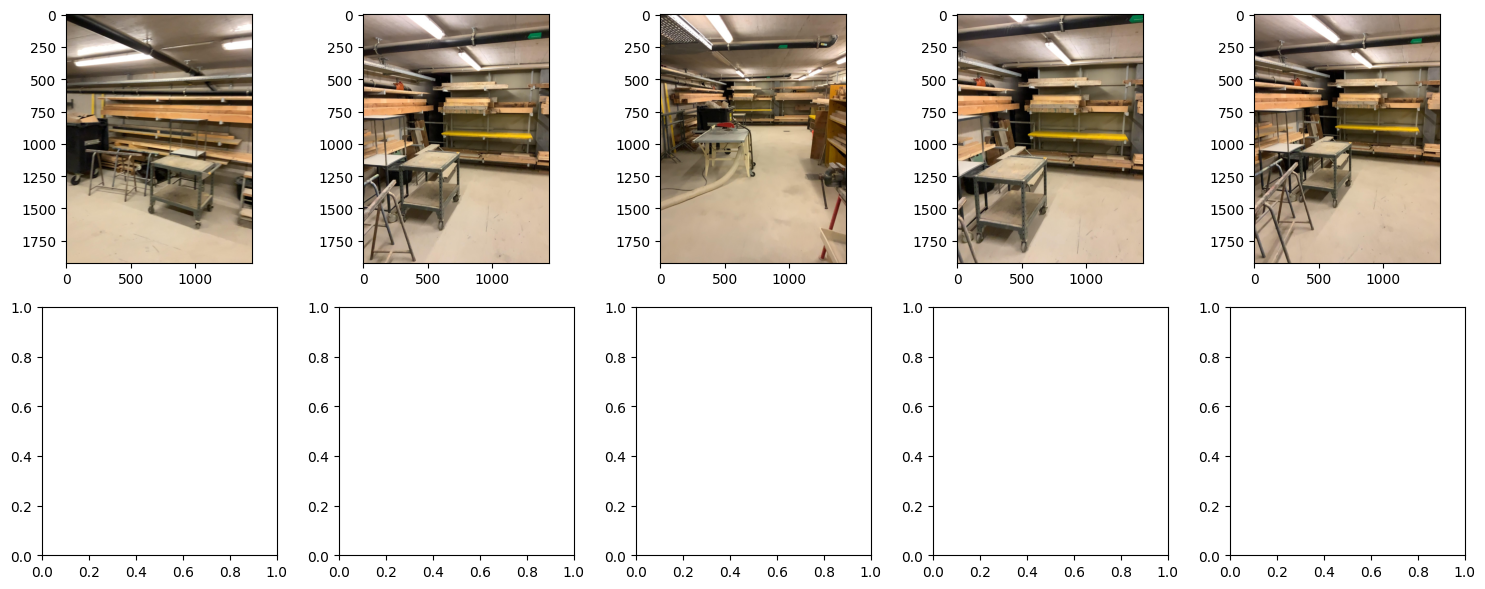

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

fig, ax = plt.subplots(2, 5, figsize=(15, 6))
axis = ax.flatten()
for i, path in enumerate(vggt_input_abspaths):
    ax = axis[i]
    img = np.asarray(Image.open(path))
    ax.imshow(img)
plt.tight_layout()
plt.show()

In [7]:
from vggt_ba.vggt_ba import CudaInference as Vggt, to_point_cloud, bundle_adjustment

vggt = Vggt() #USe as microservice

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [8]:
predictions = vggt.run(vggt_input_abspaths)

predictions['retrieval_rank'] = ranks
predictions['retrieval_score'] = score
predictions['dataset_paths'] = vggt_input_paths

/home/emmanuel/Desktop/crocodl_challenge/experiments/visual_localization/submodules/vggt/vggt/models/vggt.py:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


In [9]:

def plot_confidence_matrices_mpl(matrices, normalize_each=False):
    n, p, _ = matrices.shape
    n_cols = min(n, 3)
    n_rows = (n + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
    axes = np.atleast_1d(axes).flatten()

    # Global min/max for shared color scale
    if not normalize_each:
        vmin = np.min(matrices)
        vmax = np.max(matrices)

    for i in range(n):
        mat = matrices[i]

        if normalize_each:
            mat = normalize_matrix(mat)
            vmin, vmax = 0, 1  # normalized to [0, 1]

        im = axes[i].imshow(mat, cmap='viridis', vmin=vmin, vmax=vmax)
        axes[i].set_title(f"Matrix {i+1}")
        axes[i].axis('off')

    # Hide unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    # Colorbar for consistent scale
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()


/tmp/ipykernel_48909/2853548020.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


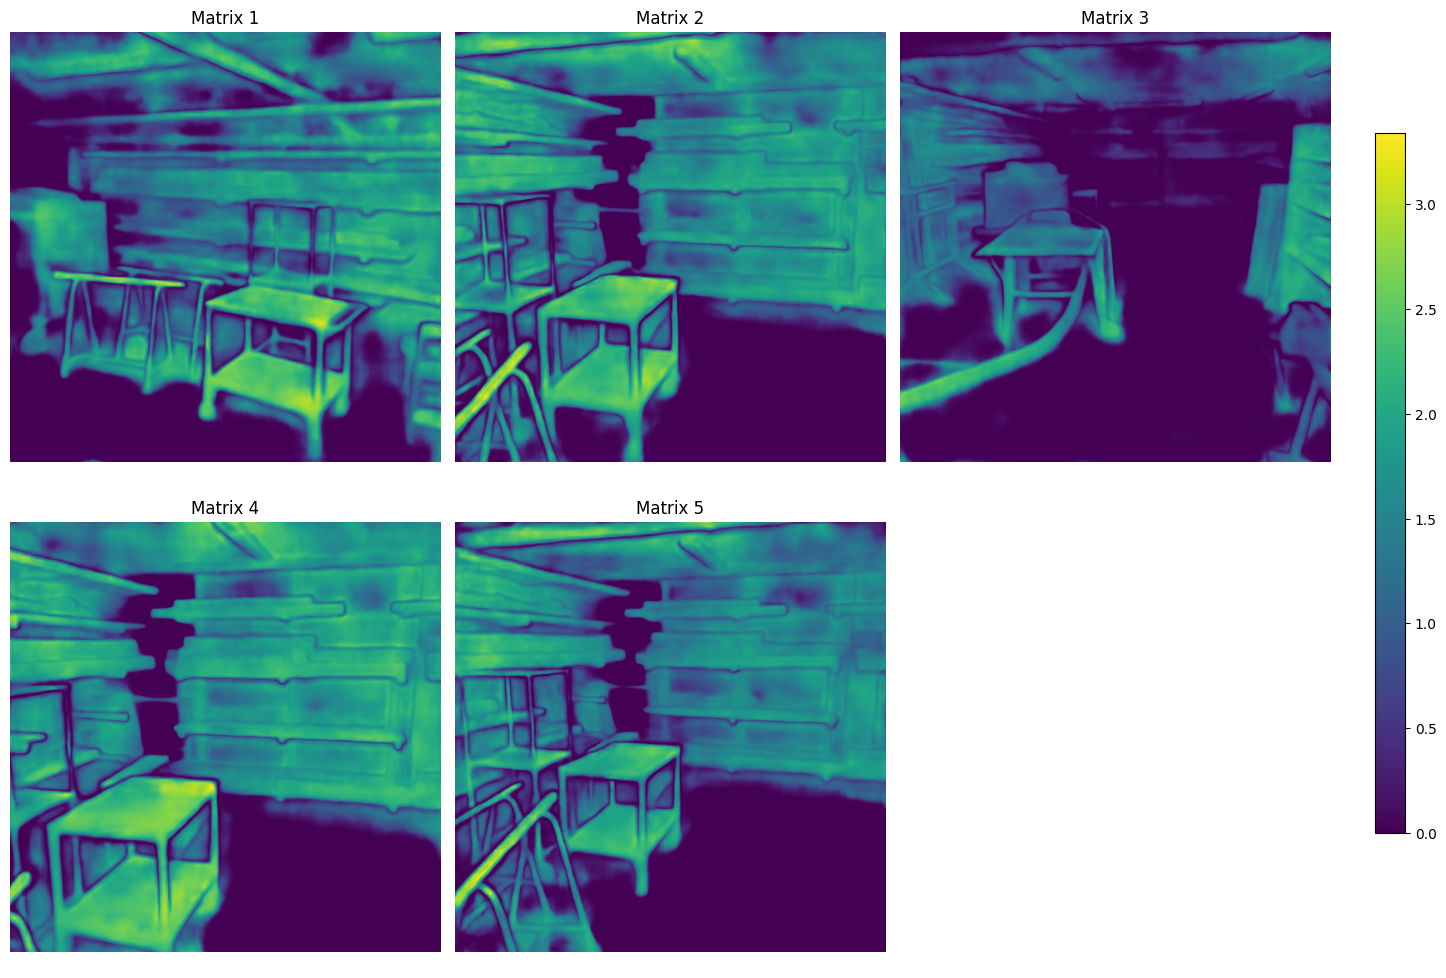

In [10]:
plot_confidence_matrices_mpl(predictions['depth_conf'] - 1)

In [ ]:
ba_results = bundle_adjustment(predictions)

In [ ]:
pcd = to_point_cloud(predictions, conf_thres=70)

In [ ]:
import open3d as o3d


o3d.visualization.draw_geometries([pcd])

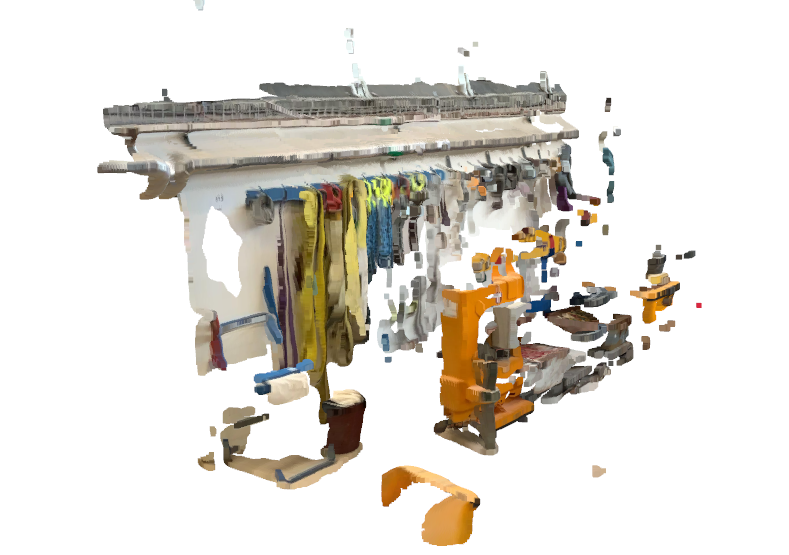